In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [3]:
def load_data(filepath):
    h5f = h5py.File(filepath, 'r')
    X_train = h5f['X_train'][:]
    y_train = h5f['y_train'][:]
    X_test = h5f['X_test'][:]
    y_test = h5f['y_test'][:]
    h5f.close()
    return (X_train, y_train), (X_test, y_test)

(X_train, y_train), (X_test, y_test) = load_data('data/RockAI_test_50_images.h5')

num_classes = 2

#Pre-process the data
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

In [4]:
import numpy as np

def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        img_h, img_w, img_c = input_img.shape
        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            c = np.random.uniform(v_l, v_h, (h, w, img_c))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w, :] = c

        return input_img

    return eraser

In [5]:
batch_size = 32

train_datagen = ImageDataGenerator(
#     get_random_eraser(v_l=0, v_h=1, pixel_level=True),
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range = 30,
    horizontal_flip=True,
    vertical_flip=True)
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, y_train, batch_size)

test_datagen = ImageDataGenerator()
test_datagen.fit(X_test)
test_generator = test_datagen.flow(X_test, y_test, batch_size)

In [6]:
image_size = (224, 224)

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

for layer in resnet_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(resnet_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(.5))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

In [7]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [19]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

historytemp = model.fit(train_generator,
                        steps_per_epoch=X_train.shape[0] // batch_size,
                        epochs=5)

Epoch 1/5
39/39 [==============================] - 9s 165ms/step - loss: 0.8261 - accuracy: 0.5850
Epoch 2/5
39/39 [==============================] - 6s 162ms/step - loss: 0.3939 - accuracy: 0.8248
Epoch 3/5
39/39 [==============================] - 6s 163ms/step - loss: 0.1899 - accuracy: 0.9485
Epoch 4/5
39/39 [==============================] - 7s 165ms/step - loss: 0.0968 - accuracy: 0.9774
Epoch 5/5
39/39 [==============================] - 7s 166ms/step - loss: 0.0789 - accuracy: 0.9826


In [20]:
model.evaluate(test_generator)

4/4 [==============================] - 1s 40ms/step - loss: 0.9818 - accuracy: 0.6800


[0.9818335771560669, 0.6800000071525574]

model.evaluate(X_test, y_test)

In [21]:
import sys
sys.path.append('/home/thanhbinh/code')
from butils.base import print_progress
from butils.imutils import load_image_file, resize
import matplotlib.pyplot as plt

[[0.09019534 0.90980464]]


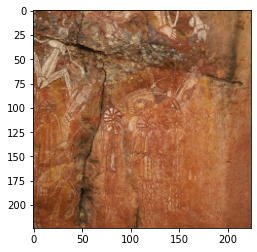

In [22]:
img = load_image_file('data/test_images/IMG_6961.JPG')
img = resize(img, image_size, keep_aspect=False, crop=False)
print(model.predict(np.array([img])))
plt.imshow(img)

[[0.03310765 0.9668923 ]]


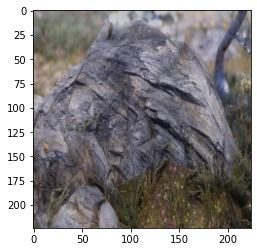

In [23]:
img = load_image_file('data/test_images/xLDuWyvV6WngkJ7dTkNbzP-970-80.jpg')
img = resize(img, image_size, keep_aspect=False, crop=False)
print(model.predict(np.array([img])))
plt.imshow(img)